| <h1> Assignment 9.1 </h1> | <h1> Convolutional Neural Networks </h1> |
|--- | --- |
Name: Buan, Danilo Jr. G. <br>
Course and Section: CPE019/CPE32S3 <br>
Date Submitted: 04/25/24 <br>
Instructor: Engr. Roman M. Richard
Date Performed: 04/26/24


Instructions:

- Choose any dataset applicable to an image classification problem
- Explain your datasets and the problem being addressed.
- Show evidence that you can do the following:
  - Using your dataset, create a baseline model of the CNN
  - Perform image augmentation
  - Perform feature standardization
  - Perform ZCA whitening of your images
  - Augment data with random rotations, shifts, and flips
  - Save augmented image data to disk
  - Develop a test harness to develop a robust evaluation of a model and establish a baseline of performance for a classification task
  - Explore extensions to a baseline model to improve learning and model capacity.
  - Develop a finalized model, evaluate the performance of the final model, and use it to make predictions on new images.

- Submit the link to your Google Colab (make sure that it is accessible to me) and the link to your dataset/s

#Classification Problem

The dataset I have chosen is from Kaggle and is focused on image classification to determine whether the object in the image is a dog or not. The problem will be addressed by creating a Convolutional Neural Network (CNN).The link for the data set is: https://www.kaggle.com/datasets/danielshanbalico/dog-vs-not-dog

In [ ]:
#Importing necessary libraries

import os
import itertools
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout,BatchNormalization

Loading the dataset

In [ ]:
data_dir = "C:/Users/user/Documents/CNN Dataset"

filepaths = []
labels = []
folds = os.listdir(data_dir)

for fold in folds:
    fold_path= os.path.join(data_dir , fold)
    filelists = os.listdir(fold_path)

    for file in filelists:
        file_path= os.path.join(fold_path , file)

        filepaths.append(file_path)
        labels.append(fold)

#Make & concatenate series & store it in dataframe
Fseries = pd.Series(filepaths, name= "filename")
Lseries = pd.Series(labels, name="label")

df = pd.concat([Fseries , Lseries], axis=1)
df.head()

filename label
0  C:/Users/user/Documents/CNN Dataset\dog\00E2uM...   dog
1  C:/Users/user/Documents/CNN Dataset\dog\00NTbu...   dog
2  C:/Users/user/Documents/CNN Dataset\dog\01MQ1f...   dog
3  C:/Users/user/Documents/CNN Dataset\dog\01NuBC...   dog
4  C:/Users/user/Documents/CNN Dataset\dog\02D2mu...   dog

Splitting the dataset into train and test datasets

In [ ]:
train_df , dummy_df = train_test_split(df , train_size=0.9 , shuffle = True ,
                                       random_state=42, stratify= df['label'])

valid_df , test_df = train_test_split(dummy_df , train_size=0.5 , shuffle = True ,
                                      random_state=42, stratify= dummy_df['label'])

Setting up data generators for training, validation, and testing datasets

In [ ]:
batch_size= 16
image_size= (224,224)

gen= ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df , x_col='filename' , y_col='label'
                                   ,class_mode='categorical', color_mode='rgb'
                                   ,shuffle=True, batch_size=batch_size
                                   ,target_size=image_size)

valid_gen = gen.flow_from_dataframe(valid_df , x_col='filename' , y_col='label'
                                   ,class_mode='categorical', color_mode='rgb'
                                   ,shuffle=True, batch_size=batch_size
                                   ,target_size=image_size)

test_gen = gen.flow_from_dataframe(test_df , x_col='filename' , y_col='label'
                                   ,class_mode='categorical', color_mode='rgb'
                                   ,shuffle=False, batch_size=batch_size
                                   ,target_size=image_size)

Found 22611 validated image filenames belonging to 2 classes.
Found 1256 validated image filenames belonging to 2 classes.
Found 1257 validated image filenames belonging to 2 classes.


Visualizing a batch of images from the dataset and feature standardizing all of them.

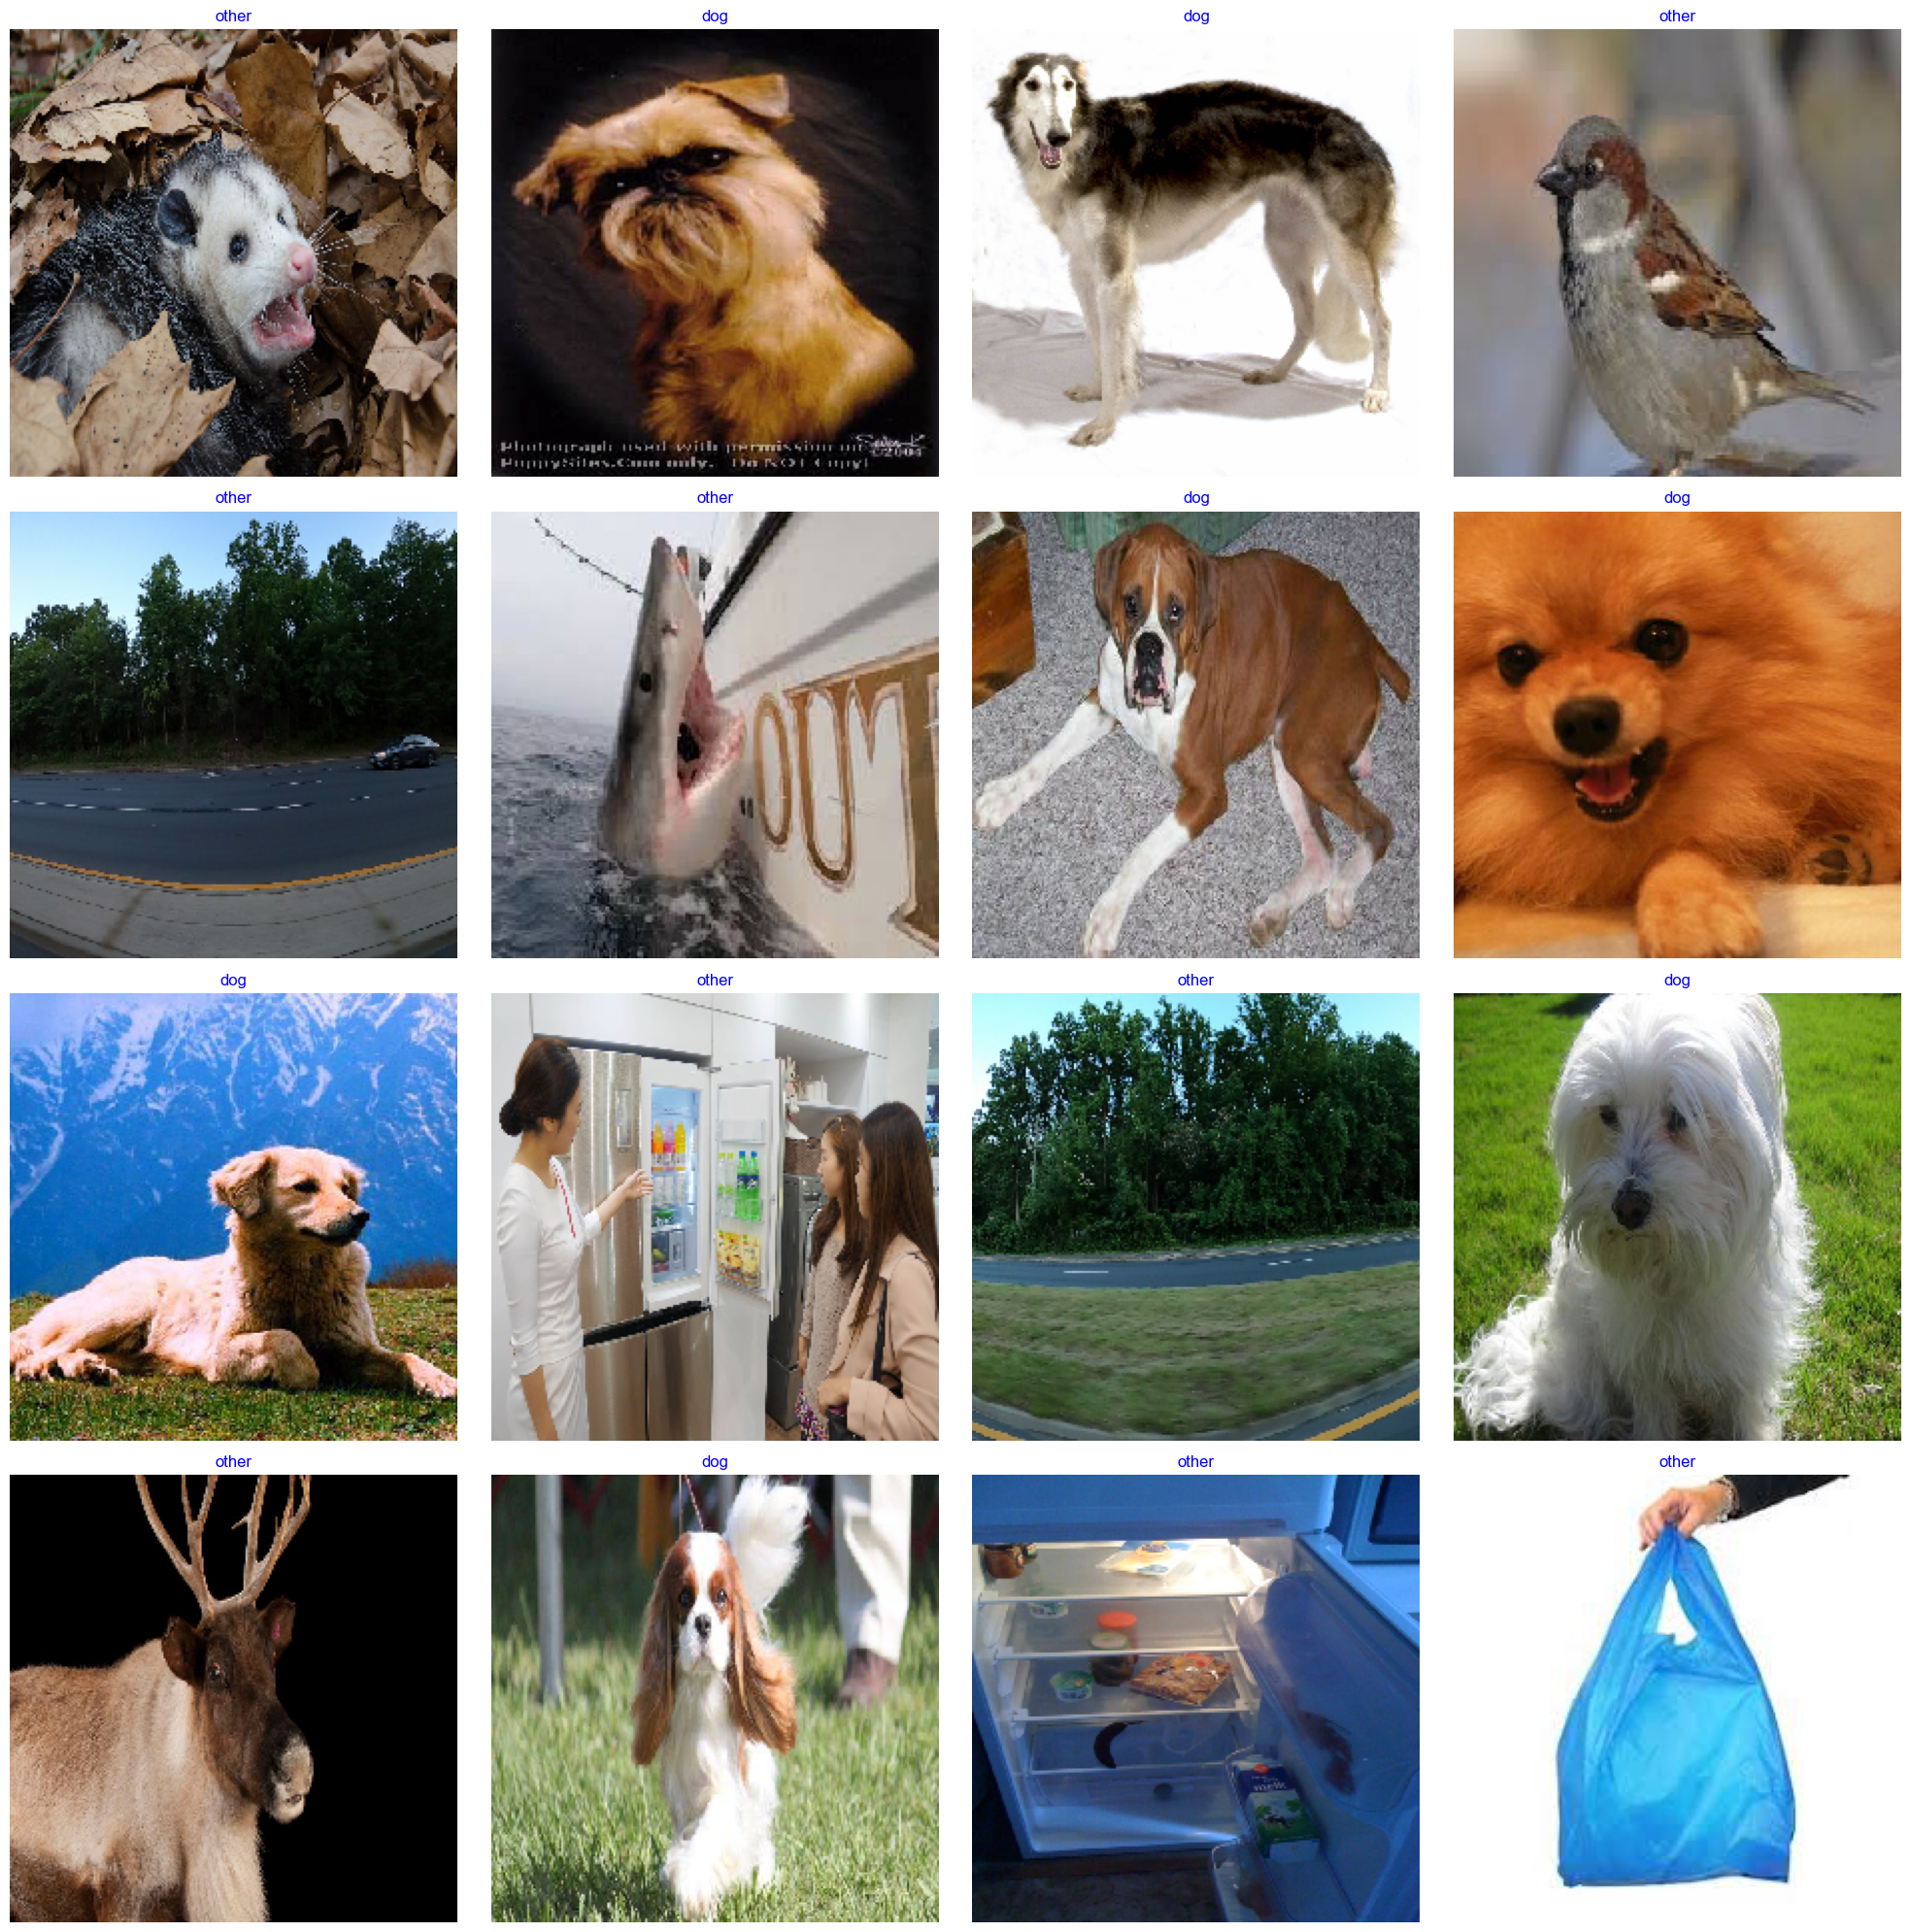

In [ ]:
gen_dict = train_gen.class_indices
classes_name = list(gen_dict.keys())

images, labels = next(train_gen)


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255 # Scalling
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes_name[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

Applying image augmentation

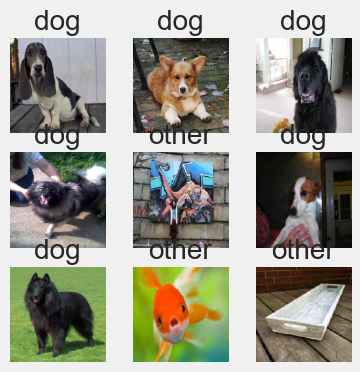

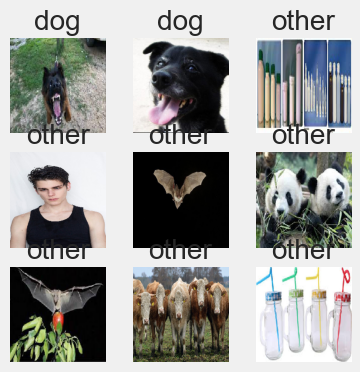

In [ ]:
import matplotlib.pyplot as plt

categories = train_gen.class_indices

# Define a function to plot images from a DataFrameIterator
def plot_images(generator, num_images=9):
    plt.figure(figsize=(4, 4))
    for i, (image, label) in enumerate(generator):
        if i == num_images:
            break
        label_index = label.argmax()  # Get the index of the label
        label_name = list(categories.keys())[list(categories.values()).index(label_index)]  # Map index to label
        plt.subplot(3, 3, i+1)
        plt.imshow(image[0] / 255)  # Plot the first image from the batch, scaling pixel values
        plt.title(label_name)
        plt.axis('off')
    plt.show()

# Plot training images with labels
plot_images(train_gen)

# Plot validation images with labels
plot_images(valid_gen)


Creating a baseline model of the CNN

In [ ]:
channels = 3
image_shape =(image_size[0], image_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu", input_shape=image_shape),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation="sigmoid")
])

model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

D:\ANACINDA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,159,010 (99.79 MB)

 Trainable params: 26,158,562 (99.79 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(train_gen, epochs= 16, verbose= 1,
                    validation_data = valid_gen, shuffle= False)

Epoch 1/16


D:\ANACINDA\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 3822s 3s/step - accuracy: 0.6836 - loss: 1.3381 - val_accuracy: 0.7269 - val_loss: 0.4942
Epoch 2/16
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 3589s 3s/step - accuracy: 0.7938 - loss: 0.4504 - val_accuracy: 0.8209 - val_loss: 0.3979
Epoch 3/16
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 3684s 3s/step - accuracy: 0.8315 - loss: 0.3686 - val_accuracy: 0.8288 - val_loss: 0.3388
Epoch 4/16
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 3616s 3s/step - accuracy: 0.8541 - loss: 0.3213 - val_accuracy: 0.8439 - val_loss: 0.3902
Epoch 5/16
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 3558s 3s/step - accuracy: 0.8854 - loss: 0.2726 - val_accuracy: 0.6346 - val_loss: 1.2418
Epoch 6/16
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 3633s 3s/step - accuracy: 0.9105 - loss: 0.2196 - val_accuracy: 0.8551 - val_loss: 0.4244
Epoch 7/16
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 3554s 3s/step - accuracy: 0.9296 - loss: 0.1746 - val_accuracy: 0.8758 - val_loss: 0.3195
Epoch 8/16
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 3533s 2s/step - accuracy: 0.9492 - loss: 0.13

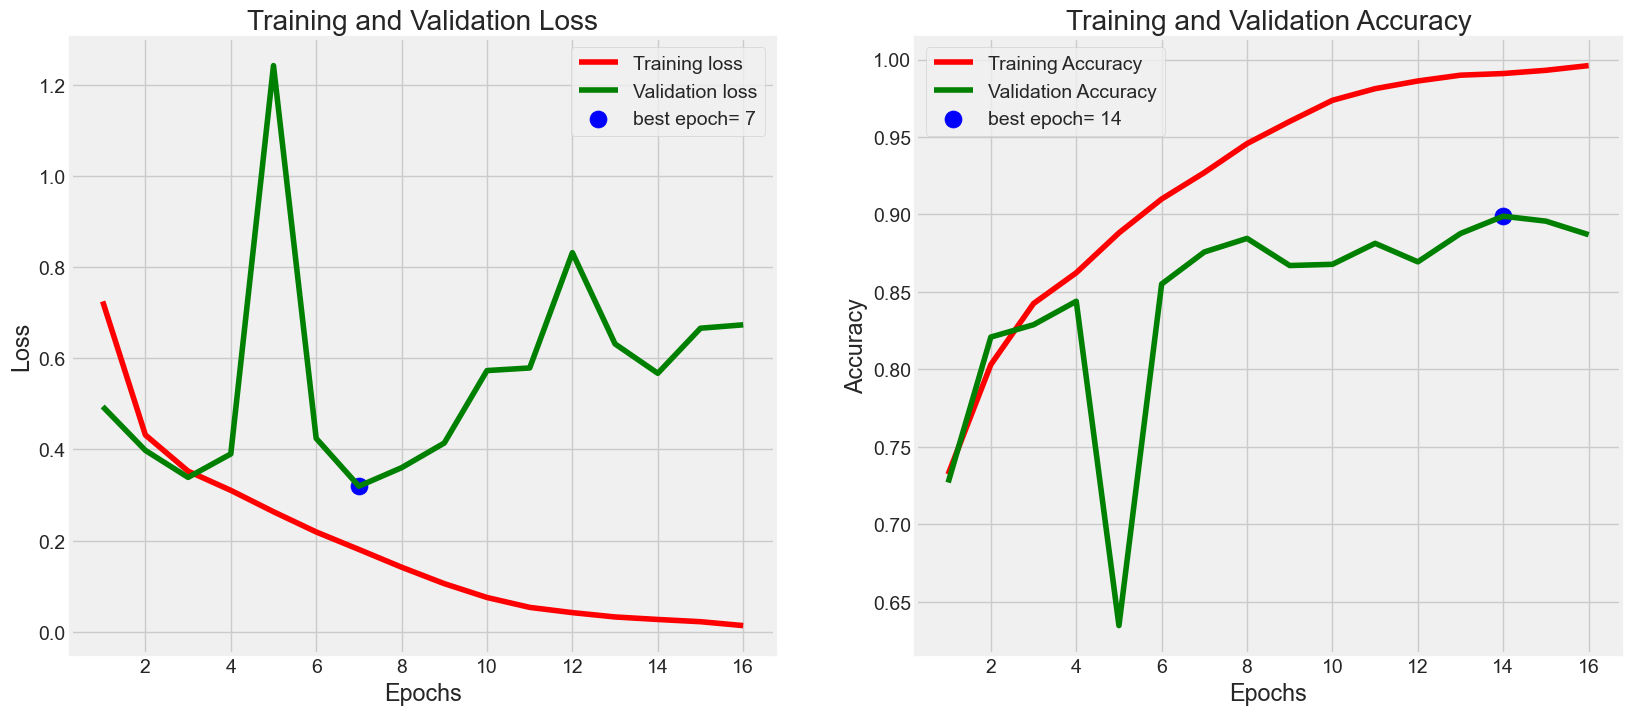

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1414/1414 ━━━━━━━━━━━━━━━━━━━━ 696s 492ms/step - accuracy: 0.9811 - loss: 0.0659
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 482ms/step - accuracy: 0.8907 - loss: 0.6310


D:\ANACINDA\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 497ms/step - accuracy: 0.8989 - loss: 0.5881
Train Loss:  0.06521789729595184
Train Accuracy:  0.9809827208518982
--------------------
Validation Loss:  0.6733210682868958
Validation Accuracy:  0.8869426846504211
--------------------
Test Loss:  0.6228330731391907
Test Accuracy:  0.8862370848655701


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 493ms/step


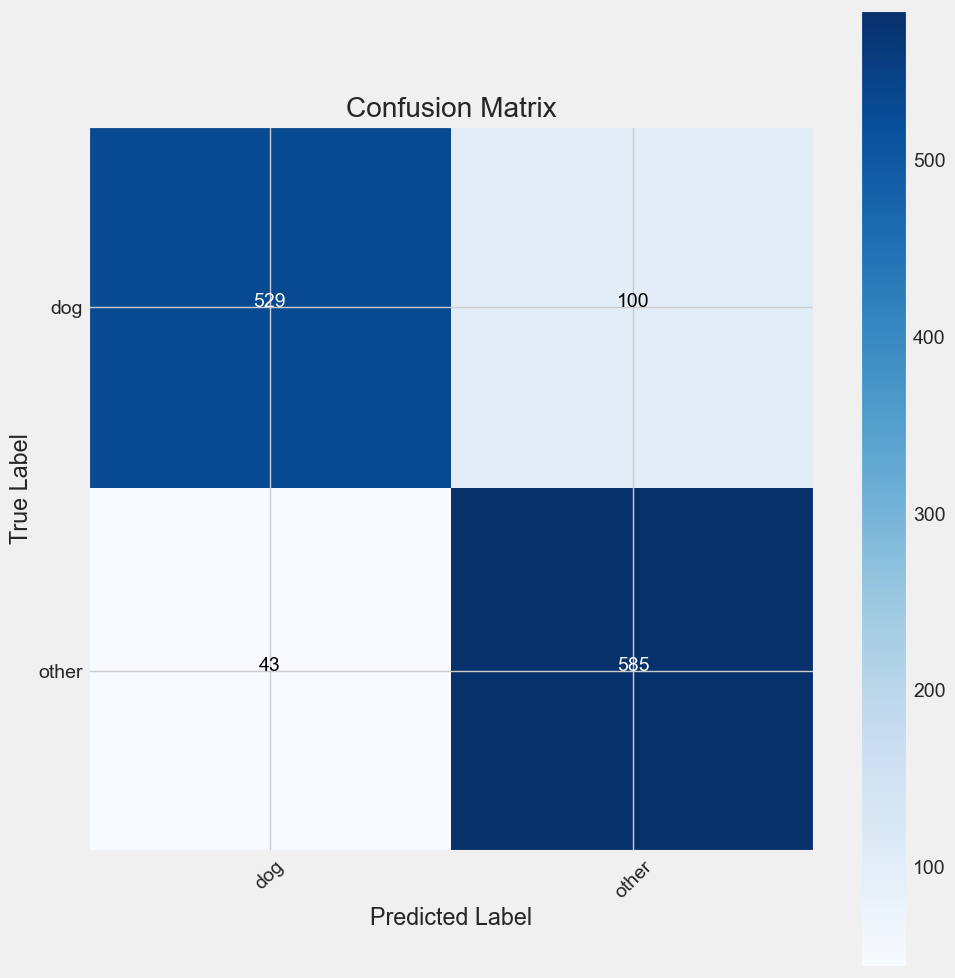

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center',
             color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred,
                            target_names= classes))

              precision    recall  f1-score   support

         dog       0.92      0.84      0.88       629
       other       0.85      0.93      0.89       628

    accuracy                           0.89      1257
   macro avg       0.89      0.89      0.89      1257
weighted avg       0.89      0.89      0.89      1257



Saving augmented image data to disk

In [ ]:
#Save the model
model.save('C:/Users/user/Documents/CNN Dataset/DogPrediction.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('C:/Users/user/Documents/CNN Dataset/DogPrediction.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'binary_crossentropy',
                     metrics= ['accuracy'])

Creating a function predict_and_display to evaluate the performance of the model

In [ ]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

def predict_and_display(image_path, model):
    # Load the image
    image = Image.open(image_path)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Preprocess the image
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model.predict(img_array)
    class_labels = ['Dog', 'Other']
    print(f"Prediction: {class_labels[np.argmax(predictions)]}")


Prediction on test images

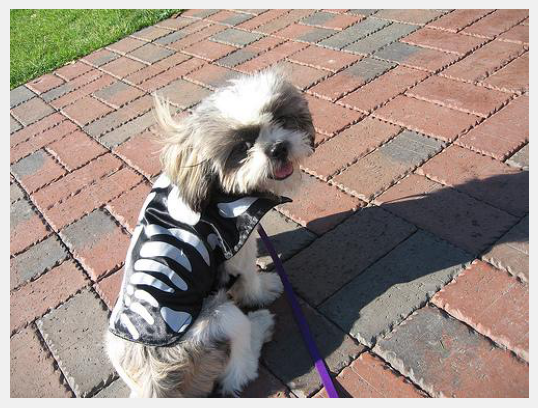

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Prediction: Dog


In [ ]:
image_path = 'C:/Users/user/Documents/CNN Dataset/dog/0GQeZFqHRM9KSjuvmvnjk2Ef9OPjHF1817.jpg'

predict_and_display(image_path, loaded_model)

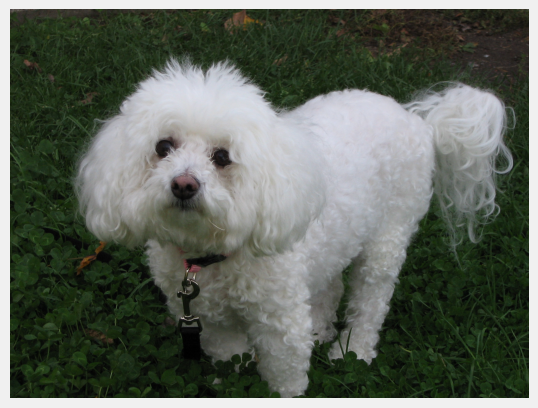

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Prediction: Dog


In [ ]:
image_path = 'C:/Users/user/Documents/CNN Dataset/dog/0MzMbxeeEZuYH7tj7LX0d8Rq8uIjn09800.jpg'

predict_and_display(image_path, loaded_model)

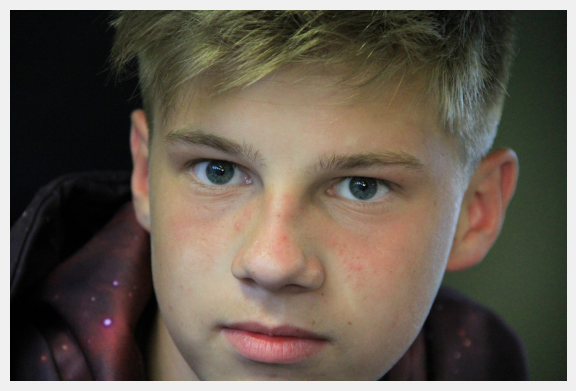

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Prediction: Other


In [ ]:
image_path = 'C:/Users/user/Documents/CNN Dataset/other/0ibMF5Ctta5OwC658Vuj4Ga76Eospy7005.jpg'

predict_and_display(image_path, loaded_model)

Prediction on new images (My own picture and our dog Sheeba)

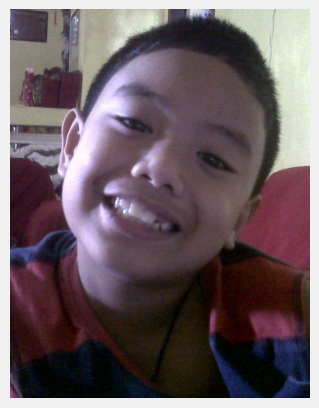

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Prediction: Other


In [ ]:
image_path = 'C:/Users/user/Documents/CNN Dataset/Dogg.jpg'

predict_and_display(image_path, loaded_model)

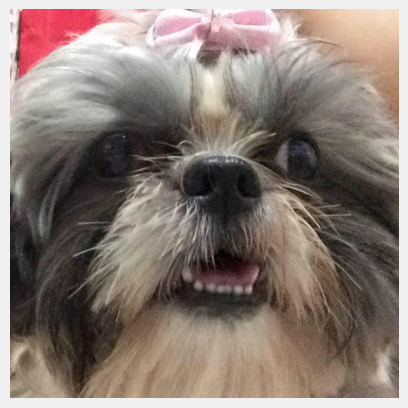

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediction: Dog


In [ ]:
image_path = 'C:/Users/user/Documents/CNN Dataset/Sheeba.jpg'

predict_and_display(image_path, loaded_model)

#Conclusion and Learning

- After performing this activity, I have learned that successful image classification requires careful dataset selection and understanding, I chose a binary classification dataset which means it is only identifying 0 or 1s (Dog or not Dog) because it was simple for me to understand. Beginning with a basic CNN model lays a strong foundation for improvement. Implementing image augmentation and feature standardization also helped me enhance the model performance and generalization. Saving augmented data ensures reproducibility, while developing a robust testing framework enables accurate performance evaluation. In conclusion, developing an image classification solution has been a valuable learning experience, emphasizing the significance of experimentation, adaptation, and continuous improvement in machine learning.